In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import combinations, cycle, islice
from Bio import pairwise2
from datetime import datetime
import multiprocessing
#from joblib import Parallel, delayed
from tqdm import tqdm
import csv

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches

# doing comparison of embedding similarity and sequence similarity between homologous and nonhomologous sequence pairs

at multiple levels of taxonomic specificity - genus, family, order, class, phylum

# do for class level

## how well do embeddings differentiate homologs

In [50]:
hom = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_class.csv")
hom.head()

,og,a_ix,b_ix,homolog,cos,seqsim
0,16305at224756,20254,20255,Homologous,0.510921,72.0
1,16305at224756,20254,20256,Homologous,0.765445,21.0
2,16305at224756,20254,20257,Homologous,0.943980,21.0
3,16305at224756,20255,20256,Homologous,0.682224,23.0
4,16305at224756,20255,20257,Homologous,0.556580,20.0


In [3]:
print(np.mean(hom[hom['homolog']=='Homologous']['cos']))
print(np.mean(hom[hom['homolog']=='Nonhomologous']['cos']))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],90))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],90))

0.6911065512279282
0.5021484117423135
0.66796625
0.36004573
0.8172142250000001
0.5947569499999998
0.89440185
0.76772577


In [35]:
def hom_boxplot(hom,fout=None):
    plt.figure(figsize=(8,8))
    box = sns.boxplot(x=hom['homolog'],y=hom['cos'],palette=['dodgerblue','tomato'])
    box.set(xlabel=' ',ylabel='embedding similarity')
    if fout:
        plt.savefig(fout,dpi=150)

ttest significance Ttest_indResult(statistic=193.58843455031558, pvalue=0.0)


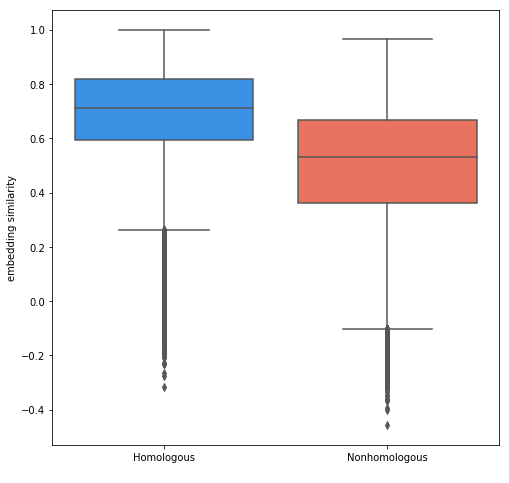

In [36]:
hom_boxplot(hom,fout='figures/homolog_boxplot_class.png')

print('ttest significance',ttest_ind(hom[hom['homolog']=='Homologous']['cos'],hom[hom['homolog']=='Nonhomologous']['cos']))

In [6]:
def get_scores(labels, preds, true_label, cutoff):
    predicted = preds>=cutoff
    true = labels==true_label
    
    TP = np.sum(np.logical_and(predicted == True, true == True))
    TN = np.sum(np.logical_and(predicted == False, true == False))
    FP = np.sum(np.logical_and(predicted == True, true == False))
    FN = np.sum(np.logical_and(predicted == False, true == True))
    
    acc = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return acc,precision,recall,f1

def metrics_plot(hom, fout=None):
    metrics = pd.DataFrame()
    for cutoff in np.arange(0.5,0.97,0.01):
        acc,precision,recall,f1 = get_scores(hom['homolog'],hom['cos'],true_label='Homologous',cutoff=cutoff)
        metrics = metrics.append([[cutoff,acc,precision,recall,f1]])
    metrics.columns = ['cutoff','accuracy','precision','recall','f1']
    
    print('cutoff where accuracy is maximum:')
    print(metrics[metrics['accuracy']==metrics['accuracy'].max()])
    max_cutoff = float(metrics[metrics['accuracy']==metrics['accuracy'].max()]['cutoff'])
    print('cutoff where F1 is maximum:')
    print(metrics[metrics['f1']==metrics['f1'].max()])
    
    colors = sns.color_palette('Set2',4)
    fig,ax = plt.subplots()
    plt.plot( 'cutoff', 'accuracy', data=metrics, color=colors[0], linewidth=3)
    plt.plot( 'cutoff', 'precision', data=metrics, color=colors[1], linewidth=3)
    plt.plot( 'cutoff', 'recall', data=metrics, color=colors[2], linewidth=3)
    plt.plot( 'cutoff', 'f1', data=metrics, color=colors[3], linewidth=3)
    plt.vlines(x=max_cutoff, ymin=0,ymax=0.99,linestyles='dashed',linewidth=1.5,color='gray')
    plt.legend()
    ax.set_xticks(ticks=np.arange(0.5,0.98,0.01),minor=True)
    ax.set_yticks(ticks=np.arange(0,1.05,0.05),minor=True)
    ax.set_xlabel('emb similarity threshold')
    plt.ylim((0,1))
    plt.xlim((0.5,0.97))
    plt.grid(b=True,which='minor',color='lightgray')
    if fout:
        plt.savefig(fout,dpi=150)

cutoff where accuracy is maximum:
   cutoff  accuracy  precision   recall        f1
0    0.61  0.683323   0.669798  0.72315  0.695452
cutoff where F1 is maximum:
   cutoff  accuracy  precision    recall        f1
0     0.5  0.659373   0.611738  0.872533  0.719224


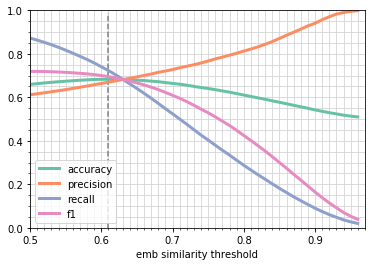

In [79]:
metrics_plot(hom,fout='figures/homolog_metrics_class.png')

## comparison seq vs emb similarity

In [15]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

scorr, _ = spearmanr(hom['seqsim'],hom['cos'])
pcorr, _ = pearsonr(hom['seqsim'],hom['cos'])
print('spearman correlation',scorr)
print('pearson correlation',pcorr)

spearman correlation 0.4972423899725378
pearson correlation 0.30111601154529705


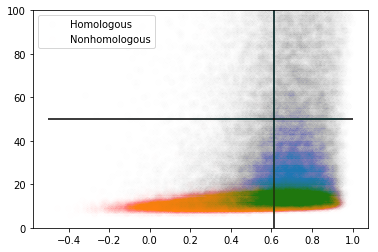

In [20]:
#plt.scatter(x='cos',y='seqsim',c='homolog',data=homseq)
#plt.show()

groups = hom.groupby("homolog")

for name, group in groups:
    plt.plot(group["cos"], group["seqsim"], marker="o", linestyle="", label=name,alpha=0.005)
plt.ylim(0,100)
plt.vlines(0.61, 0, 500)
plt.hlines(50, -0.5, 1)
plt.legend()

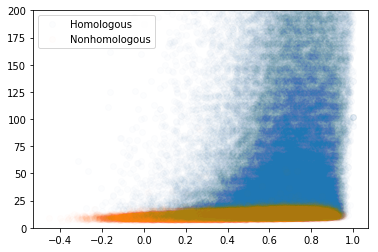

In [23]:
groups = hom.groupby("homolog")

for name, group in groups:
    plt.plot(group["cos"], group["seqsim"], marker="o", linestyle="", label=name,alpha=0.01)
plt.ylim(0,200)
plt.legend()

In [4]:
def hom_kde(hom,vline,hline=50,ylim=150,fout=None):

    homs = hom[hom['homolog']=='Homologous']
    nonhoms = hom[hom['homolog']=='Nonhomologous']

    plt.figure(figsize=(10,10))
    
    label_patches = [mpatches.Patch(color='dodgerblue',label='Homologous'), mpatches.Patch(color='tomato',label='Nonhomologous')]

    ax = sns.kdeplot(homs.cos,homs.seqsim,
                     cmap="Blues", shade=True, shade_lowest=False)

    ax = sns.kdeplot(nonhoms.cos, nonhoms.seqsim,
                     cmap="Reds", shade=True, shade_lowest=False)
    plt.vlines(vline, 0, 500,lw=1,color='grey',linestyles='dashed')
    plt.hlines(hline, -0.5, 1,lw=1,color='grey',linestyles='dashed')
    plt.ylim(0,ylim)
    plt.xlim(0,1)
    plt.xlabel('embedding similarity',fontsize=16)
    plt.ylabel('sequence similarity (bit score)', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(handles=label_patches, loc='upper left', prop={'size': 16})
    plt.tight_layout()
    if fout:
        plt.savefig(fout)

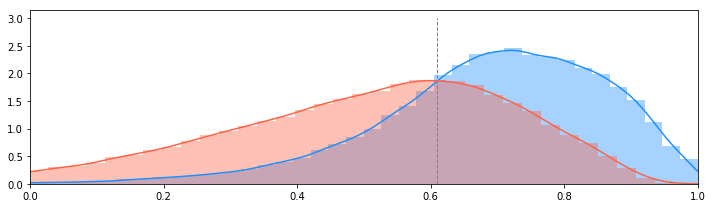

In [37]:
fout = 'figures/distplot_cos_class.png'

homs = hom[hom['homolog']=='Homologous']
nonhoms = hom[hom['homolog']=='Nonhomologous']

plt.figure(figsize=(10,3))
ax = sns.distplot(homs.cos,color="dodgerblue",kde=True)
ax = sns.distplot(nonhoms.cos,color="tomato",kde=True)
plt.xlim(0,1)
plt.vlines(0.61,0,3,lw=1,color='grey',linestyles='dashed')
plt.xlabel('')
plt.tight_layout()
plt.savefig(fout,width=500,height=200)

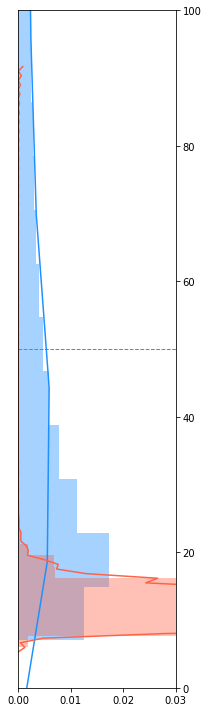

In [40]:
plt.figure(figsize=(3,10))
ax = sns.distplot(homs.seqsim,color="dodgerblue",kde=True,bins=400,vertical=True)
ax = sns.distplot(nonhoms.seqsim,color="tomato",kde=True,vertical=True)
plt.ylim(0,100)
plt.hlines(50, 0, 0.4,lw=1,color='grey',linestyles='dashed')
plt.xlim(0,0.03)
ax.yaxis.tick_right()
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/distplot_seq_class.png')

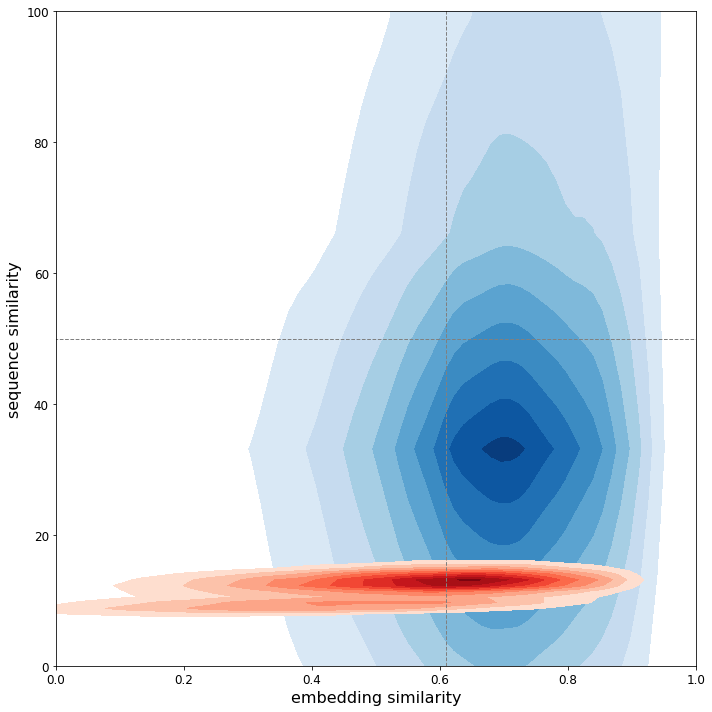

In [42]:
hom_kde(hom,vline=0.61,hline=50,ylim=100,fout='figures/kde_dualhist_class.png')

In [39]:
print(np.mean(homs.cos))
print(np.percentile(homs.cos,75))
print(np.percentile(homs.cos,25))

print(np.mean(nonhoms.cos))
print(np.percentile(nonhoms.cos,75))
print(np.percentile(nonhoms.cos,25))

print('percent of homologous pairs with <50 bit score:',len(homs[homs['seqsim']<50])/len(homs))
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.percentile(homs.seqsim,50))

0.6911065512279282
0.8172142250000001
0.5947569499999998
0.5021484117423135
0.66796625
0.36004573
percent of homologous pairs with <50 bit score: 0.4497570953720276
148.67047765155667
61.0
61.0


In [44]:
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.mean(nonhoms.seqsim))
print(np.median(nonhoms.seqsim))
print('percentage of homologous sequences with bit score <50:',len(homs[homs['seqsim']<50])/len(homs))

148.67047765155667
61.0
11.737687353130974
11.0
percentage of homologous sequences with bit score <50: 0.4497570953720276


# do for genus level

## how well do embeddings differentiate homologs

In [37]:
hom = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_genus.csv")
hom.head()

,og,a_ix,b_ix,homolog,cos,seqsim
0,40706at1883,20129,20130,Homologous,0.805239,505.0
1,40706at1883,20129,20131,Homologous,0.934404,497.0
2,40706at1883,20129,20132,Homologous,0.798783,469.0
3,40706at1883,20130,20131,Homologous,0.785393,497.0
4,40706at1883,20130,20132,Homologous,0.901292,457.0


In [46]:
print(np.mean(hom[hom['homolog']=='Homologous']['cos']))
print(np.mean(hom[hom['homolog']=='Nonhomologous']['cos']))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],90))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],90))

0.8095853989099996
0.507237415884781
0.679956165
0.36006192
0.9245720425000001
0.7241942575
0.9675302760000002
0.780883803


ttest significance Ttest_indResult(statistic=326.0823099203712, pvalue=0.0)


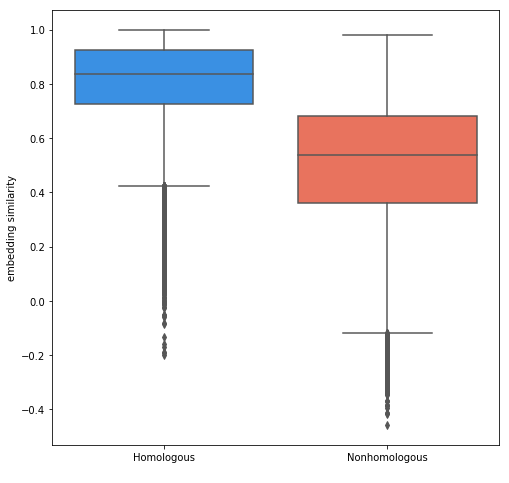

In [38]:
hom_boxplot(hom,fout='figures/homolog_boxplot_genus.png')

print('ttest significance',ttest_ind(hom[hom['homolog']=='Homologous']['cos'],hom[hom['homolog']=='Nonhomologous']['cos']))

cutoff where accuracy is maximum:
   cutoff  accuracy  precision    recall        f1
0     0.7  0.789242   0.786663  0.793741  0.790186
cutoff where F1 is maximum:
   cutoff  accuracy  precision    recall        f1
0    0.65  0.782425   0.741655  0.866781  0.799351


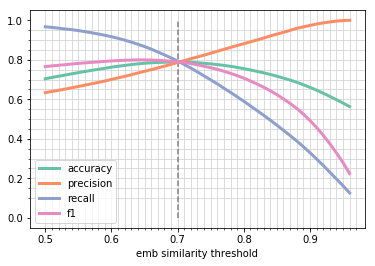

In [27]:
metrics_plot(hom,fout='figures/homolog_metrics_genus.png')

## comparison seq vs emb similarity

In [49]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

scorr, _ = spearmanr(hom['seqsim'],hom['cos'])
pcorr, _ = pearsonr(hom['seqsim'],hom['cos'])
print('spearman correlation',scorr)
print('pearson correlation',pcorr)

spearman correlation 0.6872640556480618
pearson correlation 0.44479984394271627


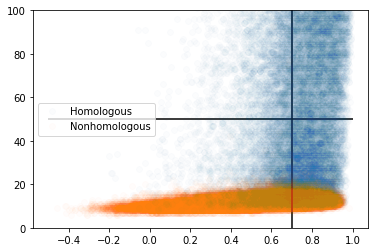

In [51]:
#plt.scatter(x='cos',y='seqsim',c='homolog',data=homseq)
#plt.show()

groups = hom.groupby("homolog")

for name, group in groups:
    plt.plot(group["cos"], group["seqsim"], marker="o", linestyle="", label=name,alpha=0.015)
plt.ylim(0,100)
plt.vlines(0.7, 0, 500)
plt.hlines(50, -0.5, 1)
plt.legend()

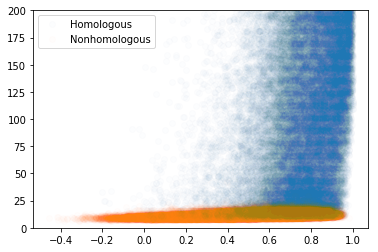

In [52]:
groups = hom.groupby("homolog")

for name, group in groups:
    plt.plot(group["cos"], group["seqsim"], marker="o", linestyle="", label=name,alpha=0.01)
plt.ylim(0,200)
plt.legend()

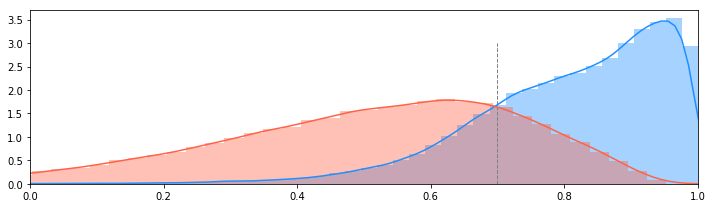

In [53]:
fout = 'figures/distplot_cos_genus.png'

homs = hom[hom['homolog']=='Homologous']
nonhoms = hom[hom['homolog']=='Nonhomologous']

plt.figure(figsize=(10,3))
ax = sns.distplot(homs.cos,color="dodgerblue",kde=True)
ax = sns.distplot(nonhoms.cos,color="tomato",kde=True)
plt.xlim(0,1)
plt.vlines(0.7,0,3,lw=1,color='grey',linestyles='dashed')
plt.xlabel('')
plt.tight_layout()
plt.savefig(fout,width=500,height=200)

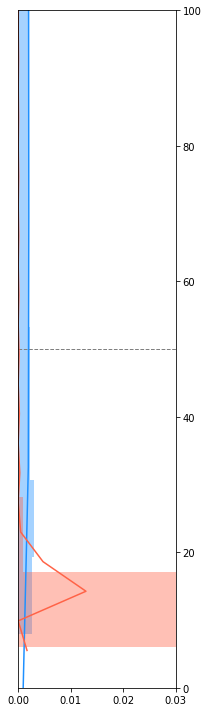

In [56]:
plt.figure(figsize=(3,10))
ax = sns.distplot(homs.seqsim,color="dodgerblue",kde=True,bins=400,vertical=True)
ax = sns.distplot(nonhoms.seqsim,color="tomato",kde=True,vertical=True)
plt.ylim(0,100)
plt.hlines(50, 0, 0.4,lw=1,color='grey',linestyles='dashed')
plt.xlim(0,0.03)
ax.yaxis.tick_right()
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/distplot_seq_genus.png')

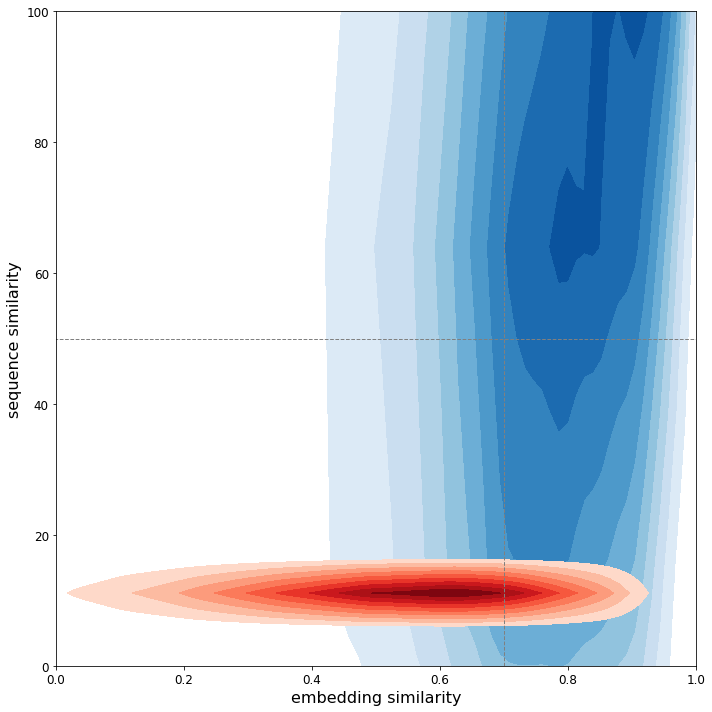

In [57]:
hom_kde(hom,vline=0.7,hline=50,ylim=100,fout='figures/kde_dualhist_genus.png')

In [58]:
print(np.mean(homs.cos))
print(np.percentile(homs.cos,75))
print(np.percentile(homs.cos,25))

print(np.mean(nonhoms.cos))
print(np.percentile(nonhoms.cos,75))
print(np.percentile(nonhoms.cos,25))

print('percent of homologous pairs with <50 bit score:',len(homs[homs['seqsim']<50])/len(homs))
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.percentile(homs.seqsim,50))

0.8095853989099996
0.9245720425000001
0.7241942575
0.507237415884781
0.679956165
0.36006192
percent of homologous pairs with <50 bit score: 0.10735510863880568
346.54290876242095
261.0
261.0


In [59]:
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.mean(nonhoms.seqsim))
print(np.median(nonhoms.seqsim))
print('percentage of homologous sequences with bit score <50:',len(homs[homs['seqsim']<50])/len(homs))

346.54290876242095
261.0
11.453893881044074
11.0
percentage of homologous sequences with bit score <50: 0.10735510863880568


# do for family level

## how well do embeddings differentiate homologs

In [39]:
hom = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_family.csv")
hom.head()

,og,a_ix,b_ix,homolog,cos,seqsim
0,845at2272,42432,42433,Homologous,0.891654,291.0
1,845at2272,42432,42434,Homologous,0.707814,101.0
2,845at2272,42432,42435,Homologous,0.495029,103.0
3,845at2272,42432,42436,Homologous,0.792022,168.0
4,845at2272,42433,42434,Homologous,0.752038,113.0


In [62]:
print(np.mean(hom[hom['homolog']=='Homologous']['cos']))
print(np.mean(hom[hom['homolog']=='Nonhomologous']['cos']))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],90))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],90))

0.7766838441945256
0.5007426944469954
0.671337175
0.35539265249999996
0.8922224250000002
0.6878546475
0.9489330050000002
0.77572682


ttest significance Ttest_indResult(statistic=297.91956541863055, pvalue=0.0)


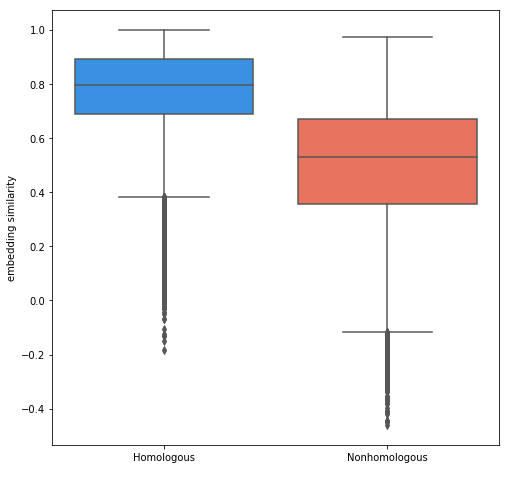

In [40]:
hom_boxplot(hom,fout='figures/homolog_boxplot_family.png')

print('ttest significance',ttest_ind(hom[hom['homolog']=='Homologous']['cos'],hom[hom['homolog']=='Nonhomologous']['cos']))

cutoff where accuracy is maximum:
   cutoff  accuracy  precision    recall        f1
0    0.67  0.766089   0.756565  0.784651  0.770352
cutoff where F1 is maximum:
   cutoff  accuracy  precision    recall        f1
0    0.61  0.757774    0.70911  0.874131  0.783021


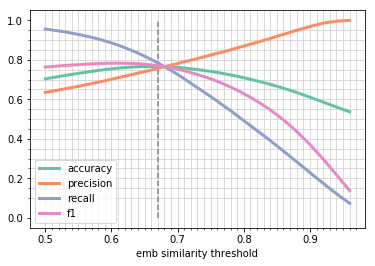

In [29]:
metrics_plot(hom,fout='figures/homolog_metrics_family.png')

## comparison seq vs emb similarity

In [67]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

scorr, _ = spearmanr(hom['seqsim'],hom['cos'])
pcorr, _ = pearsonr(hom['seqsim'],hom['cos'])
print('spearman correlation',scorr)
print('pearson correlation',pcorr)

spearman correlation 0.6537910365366844
pearson correlation 0.4055716358218051


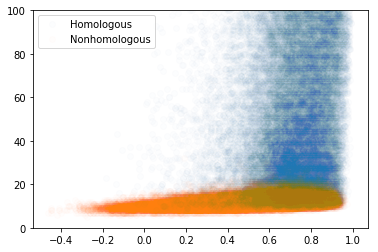

In [73]:
groups = hom.groupby("homolog")

for name, group in groups:
    plt.plot(group["cos"], group["seqsim"], marker="o", linestyle="", label=name,alpha=0.01)
plt.ylim(0,100)
plt.legend()

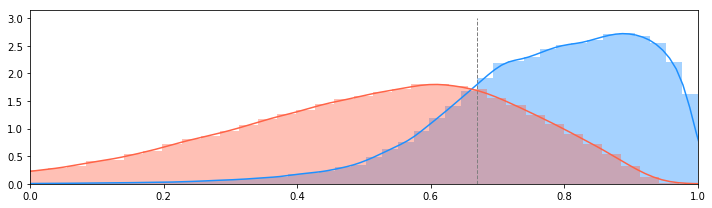

In [71]:
fout = 'figures/distplot_cos_family.png'

homs = hom[hom['homolog']=='Homologous']
nonhoms = hom[hom['homolog']=='Nonhomologous']

plt.figure(figsize=(10,3))
ax = sns.distplot(homs.cos,color="dodgerblue",kde=True)
ax = sns.distplot(nonhoms.cos,color="tomato",kde=True)
plt.xlim(0,1)
plt.vlines(0.67,0,3,lw=1,color='grey',linestyles='dashed')
plt.xlabel('')
plt.tight_layout()
plt.savefig(fout,width=500,height=200)

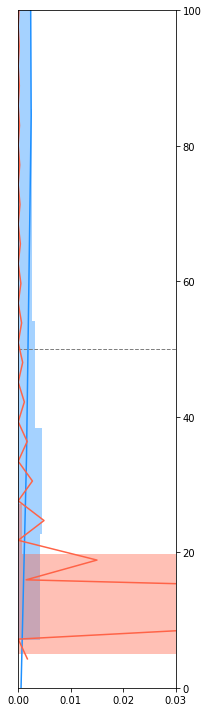

In [72]:
plt.figure(figsize=(3,10))
ax = sns.distplot(homs.seqsim,color="dodgerblue",kde=True,bins=400,vertical=True)
ax = sns.distplot(nonhoms.seqsim,color="tomato",kde=True,vertical=True)
plt.ylim(0,100)
plt.hlines(50, 0, 0.4,lw=1,color='grey',linestyles='dashed')
plt.xlim(0,0.03)
ax.yaxis.tick_right()
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/distplot_seq_family.png')

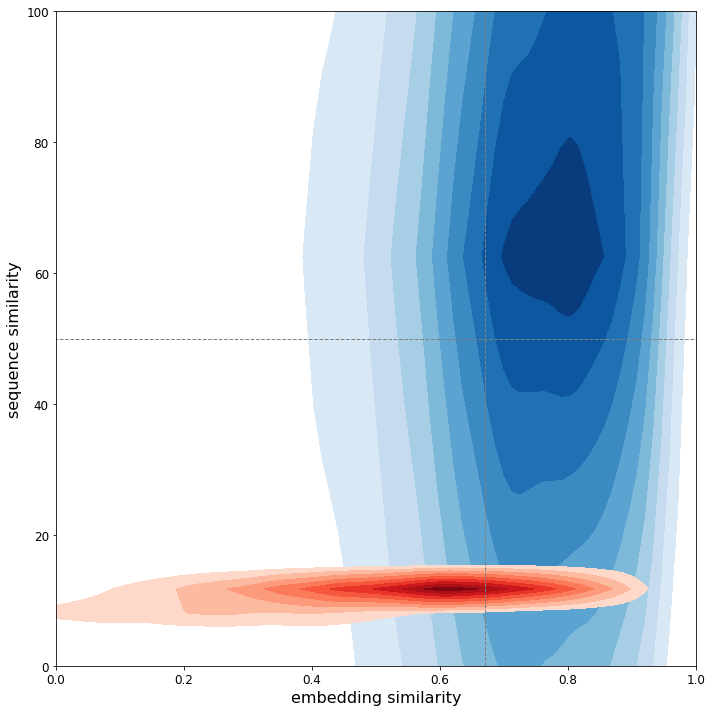

In [74]:
hom_kde(hom,vline=0.67,hline=50,ylim=100,fout='figures/kde_dualhist_family.png')

In [75]:
print(np.mean(homs.cos))
print(np.percentile(homs.cos,75))
print(np.percentile(homs.cos,25))

print(np.mean(nonhoms.cos))
print(np.percentile(nonhoms.cos,75))
print(np.percentile(nonhoms.cos,25))

print('percent of homologous pairs with <50 bit score:',len(homs[homs['seqsim']<50])/len(homs))
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.percentile(homs.seqsim,50))

0.7766838441945256
0.8922224250000002
0.6878546475
0.5007426944469954
0.671337175
0.35539265249999996
percent of homologous pairs with <50 bit score: 0.17315138791695825
279.2286097504082
195.0
195.0


In [76]:
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.mean(nonhoms.seqsim))
print(np.median(nonhoms.seqsim))
print('percentage of homologous sequences with bit score <50:',len(homs[homs['seqsim']<50])/len(homs))

279.2286097504082
195.0
11.511674830884068
11.0
percentage of homologous sequences with bit score <50: 0.17315138791695825


# do for order level

## how well do embeddings differentiate homologs

In [41]:
hom = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_order.csv")
hom.head()

,og,a_ix,b_ix,homolog,cos,seqsim
0,10494at2235,38863,38864,Homologous,0.785466,341.0
1,10494at2235,38863,38865,Homologous,0.959310,345.0
2,10494at2235,38863,38866,Homologous,0.895459,338.0
3,10494at2235,38863,38867,Homologous,0.888944,337.0
4,10494at2235,38864,38865,Homologous,0.859572,397.0


In [78]:
print(np.mean(hom[hom['homolog']=='Homologous']['cos']))
print(np.mean(hom[hom['homolog']=='Nonhomologous']['cos']))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],90))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],90))

0.7342641820614275
0.5023843936202723
0.660583705
0.368333865
0.8526760250000001
0.640960305
0.9187877280000001
0.762691464


ttest significance Ttest_indResult(statistic=255.12963589006458, pvalue=0.0)


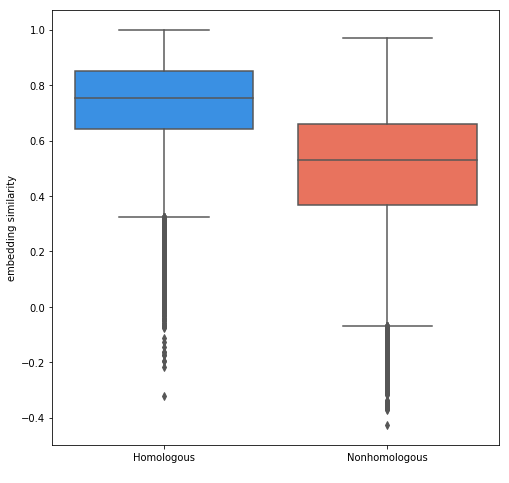

In [42]:
hom_boxplot(hom,fout='figures/homolog_boxplot_order.png')

print('ttest significance',ttest_ind(hom[hom['homolog']=='Homologous']['cos'],hom[hom['homolog']=='Nonhomologous']['cos']))

cutoff where accuracy is maximum:
   cutoff  accuracy  precision    recall        f1
0    0.63  0.732053    0.71559  0.770232  0.741907
cutoff where F1 is maximum:
   cutoff  accuracy  precision    recall        f1
0    0.57  0.719896   0.671322  0.861659  0.754674


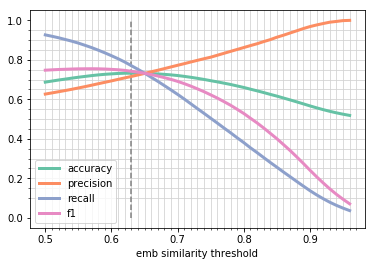

In [31]:
metrics_plot(hom,fout='figures/homolog_metrics_order.png')

## comparison seq vs emb similarity

In [84]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

scorr, _ = spearmanr(hom['seqsim'],hom['cos'])
pcorr, _ = pearsonr(hom['seqsim'],hom['cos'])
print('spearman correlation',scorr)
print('pearson correlation',pcorr)

spearman correlation 0.5883994470115332
pearson correlation 0.36533725356413566


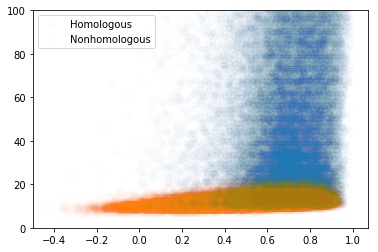

In [85]:
groups = hom.groupby("homolog")

for name, group in groups:
    plt.plot(group["cos"], group["seqsim"], marker="o", linestyle="", label=name,alpha=0.01)
plt.ylim(0,100)
plt.legend()

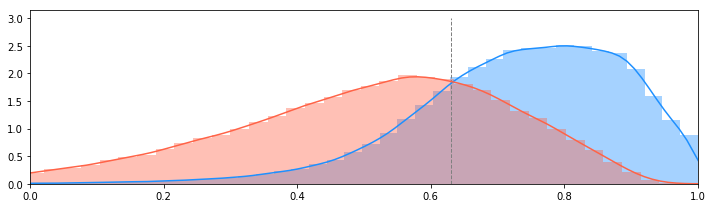

In [86]:
fout = 'figures/distplot_cos_order.png'

homs = hom[hom['homolog']=='Homologous']
nonhoms = hom[hom['homolog']=='Nonhomologous']

plt.figure(figsize=(10,3))
ax = sns.distplot(homs.cos,color="dodgerblue",kde=True)
ax = sns.distplot(nonhoms.cos,color="tomato",kde=True)
plt.xlim(0,1)
plt.vlines(0.63,0,3,lw=1,color='grey',linestyles='dashed')
plt.xlabel('')
plt.tight_layout()
plt.savefig(fout,width=500,height=200)

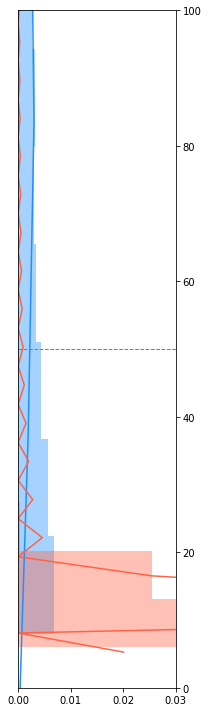

In [87]:
plt.figure(figsize=(3,10))
ax = sns.distplot(homs.seqsim,color="dodgerblue",kde=True,bins=400,vertical=True)
ax = sns.distplot(nonhoms.seqsim,color="tomato",kde=True,vertical=True)
plt.ylim(0,100)
plt.hlines(50, 0, 0.4,lw=1,color='grey',linestyles='dashed')
plt.xlim(0,0.03)
ax.yaxis.tick_right()
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/distplot_seq_order.png')

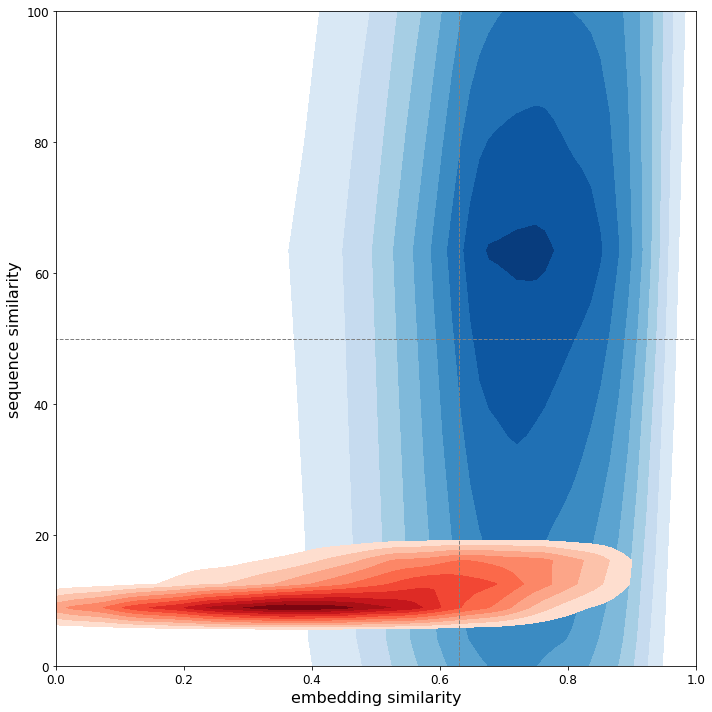

In [88]:
hom_kde(hom,vline=0.63,hline=50,ylim=100,fout='figures/kde_dualhist_order.png')

In [89]:
print(np.mean(homs.cos))
print(np.percentile(homs.cos,75))
print(np.percentile(homs.cos,25))

print(np.mean(nonhoms.cos))
print(np.percentile(nonhoms.cos,75))
print(np.percentile(nonhoms.cos,25))

print('percent of homologous pairs with <50 bit score:',len(homs[homs['seqsim']<50])/len(homs))
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.percentile(homs.seqsim,50))

0.7342641820614275
0.8526760250000001
0.640960305
0.5023843936202723
0.660583705
0.368333865
percent of homologous pairs with <50 bit score: 0.2320409621896493
232.29896774344735
144.0
144.0


In [97]:
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.mean(nonhoms.seqsim))
print(np.median(nonhoms.seqsim))
print('percentage of homologous sequences with bit score <50:',len(homs[homs['seqsim']<50])/len(homs))

232.29896774344735
144.0
11.81583418280666
11.0
percentage of homologous sequences with bit score <50: 0.2320409621896493


# do for phylum level

## how well do embeddings differentiate homologs

In [2]:
hom = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_phylum.csv")
hom.head()

,og,a_ix,b_ix,homolog,cos,seqsim
0,1987at200795,8106,8107,Homologous,0.832815,343.0
1,1987at200795,8106,8108,Homologous,0.826390,122.0
2,1987at200795,8106,8109,Homologous,0.829072,107.0
3,1987at200795,8106,8110,Homologous,0.841431,273.0
4,1987at200795,8107,8108,Homologous,0.777087,158.0


In [7]:
metrics_seqsim = pd.DataFrame()
for cutoff in np.arange(0,100,10):
    acc,precision,recall,f1 = get_scores(hom['homolog'],hom['seqsim'],true_label='Homologous',cutoff=cutoff)
    metrics_seqsim = metrics_seqsim.append([[cutoff,acc,precision,recall,f1]])
metrics_seqsim.columns = ['cutoff','accuracy','precision','recall','f1']
metrics_seqsim

,cutoff,accuracy,precision,recall,f1
0,0,0.500000,0.500000,1.000000,0.666667
0,10,0.549190,0.526061,0.992928,0.687748
0,20,0.898256,0.994672,0.800802,0.887270
0,30,0.841167,0.999695,0.682542,0.811222
0,40,0.804834,0.999859,0.609753,0.757533
0,50,0.778183,0.999912,0.556415,0.714973
0,60,0.756722,0.999928,0.513482,0.678527
0,70,0.739031,0.999923,0.478098,0.646894
0,80,0.723576,0.999918,0.447188,0.617994
0,90,0.710027,0.999942,0.420078,0.591616


In [3]:
print(np.mean(hom[hom['homolog']=='Homologous']['cos']))
print(np.mean(hom[hom['homolog']=='Nonhomologous']['cos']))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],75))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],25))
print(np.percentile(hom[hom['homolog']=='Homologous']['cos'],90))
print(np.percentile(hom[hom['homolog']=='Nonhomologous']['cos'],90))

0.67932348917908
0.512697397487232
0.6731081625
0.378319155
0.811837745
0.578439925
0.8920624850000001
0.7726198870000001


ttest significance Ttest_indResult(statistic=168.6272203747017, pvalue=0.0)


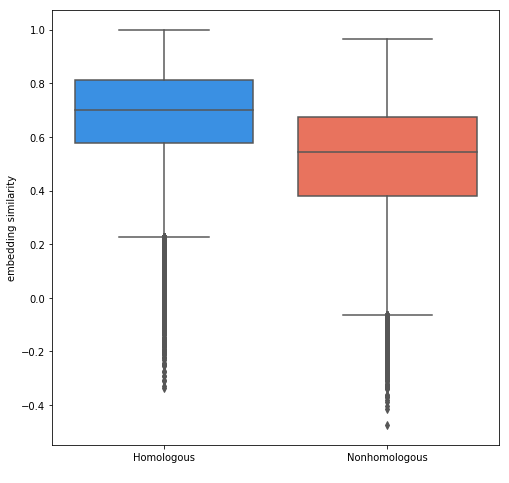

In [44]:
hom_boxplot(hom,fout='figures/homolog_boxplot_phylum.png')

print('ttest significance',ttest_ind(hom[hom['homolog']=='Homologous']['cos'],hom[hom['homolog']=='Nonhomologous']['cos']))

cutoff where accuracy is maximum:
   cutoff  accuracy  precision    recall        f1
0    0.62  0.663705   0.659498  0.676892  0.668082
cutoff where F1 is maximum:
   cutoff  accuracy  precision    recall        f1
0     0.5  0.638868   0.597421  0.851591  0.702214


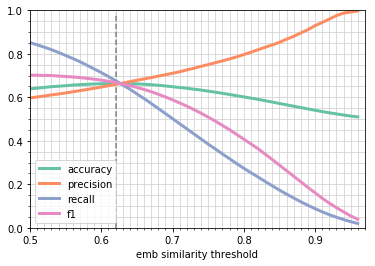

In [81]:
metrics_plot(hom,fout='figures/homolog_metrics_phylum.png')

## comparison seq vs emb similarity

In [95]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

scorr, _ = spearmanr(hom['seqsim'],hom['cos'])
pcorr, _ = pearsonr(hom['seqsim'],hom['cos'])
print('spearman correlation',scorr)
print('pearson correlation',pcorr)

spearman correlation 0.4691824533773271
pearson correlation 0.28348049166086847


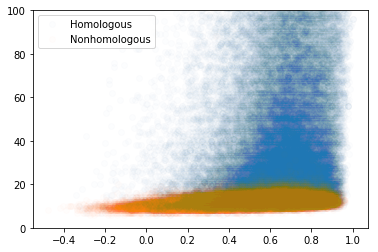

In [96]:
groups = hom.groupby("homolog")

for name, group in groups:
    plt.plot(group["cos"], group["seqsim"], marker="o", linestyle="", label=name,alpha=0.01)
plt.ylim(0,100)
plt.legend()

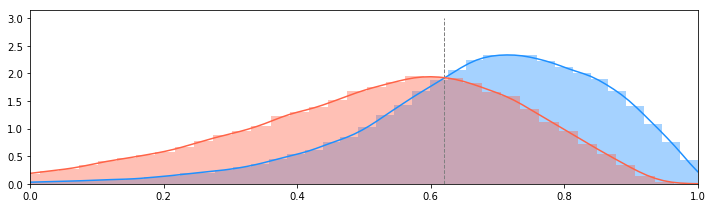

In [98]:
fout = 'figures/distplot_cos_phylum.png'

homs = hom[hom['homolog']=='Homologous']
nonhoms = hom[hom['homolog']=='Nonhomologous']

plt.figure(figsize=(10,3))
ax = sns.distplot(homs.cos,color="dodgerblue",kde=True)
ax = sns.distplot(nonhoms.cos,color="tomato",kde=True)
plt.xlim(0,1)
plt.vlines(0.62,0,3,lw=1,color='grey',linestyles='dashed')
plt.xlabel('')
plt.tight_layout()
plt.savefig(fout,width=500,height=200)

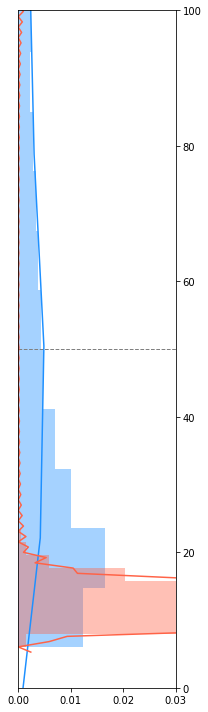

In [99]:
plt.figure(figsize=(3,10))
ax = sns.distplot(homs.seqsim,color="dodgerblue",kde=True,bins=400,vertical=True)
ax = sns.distplot(nonhoms.seqsim,color="tomato",kde=True,vertical=True)
plt.ylim(0,100)
plt.hlines(50, 0, 0.4,lw=1,color='grey',linestyles='dashed')
plt.xlim(0,0.03)
ax.yaxis.tick_right()
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/distplot_seq_phylum.png')

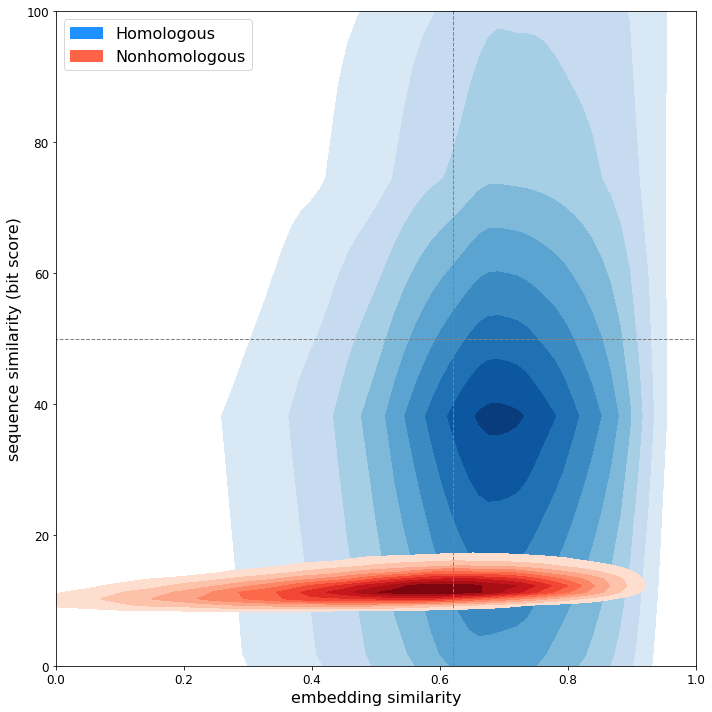

In [5]:
hom_kde(hom,vline=0.62,hline=50,ylim=100,fout='figures/kde_dualhist_phylum.png')

In [101]:
print(np.mean(homs.cos))
print(np.percentile(homs.cos,75))
print(np.percentile(homs.cos,25))

print(np.mean(nonhoms.cos))
print(np.percentile(nonhoms.cos,75))
print(np.percentile(nonhoms.cos,25))

print('percent of homologous pairs with <50 bit score:',len(homs[homs['seqsim']<50])/len(homs))
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.percentile(homs.seqsim,50))

0.67932348917908
0.811837745
0.578439925
0.512697397487232
0.6731081625
0.378319155
percent of homologous pairs with <50 bit score: 0.4435851554073929
148.5819075399549
63.0
63.0


In [102]:
print(np.mean(homs.seqsim))
print(np.median(homs.seqsim))
print(np.mean(nonhoms.seqsim))
print(np.median(nonhoms.seqsim))
print('percentage of homologous sequences with bit score <50:',len(homs[homs['seqsim']<50])/len(homs))

148.5819075399549
63.0
11.850512305127953
12.0
percentage of homologous sequences with bit score <50: 0.4435851554073929


# get accuracy over threshold for all levels

for SI fig

In [103]:
phylum = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_phylum.csv")
classdf = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_class.csv")
order = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_order.csv")
family = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_family.csv")
genus = pd.read_csv("LookingGlass_Similarities_out/Homolog_Emb_Seq_Comp_genus.csv")

In [104]:
def append_metrics(metrics,df,label):
    for cutoff in np.arange(0.5,0.97,0.01):
        acc,precision,recall,f1 = get_scores(df['homolog'],df['cos'],true_label='Homologous',cutoff=cutoff)
        metrics = metrics.append([[cutoff,acc,precision,recall,f1,label]])
    return metrics


In [105]:
metrics = pd.DataFrame()
metrics = append_metrics(metrics,phylum,label='phylum')
metrics = append_metrics(metrics,classdf,label='class')
metrics = append_metrics(metrics,order,label='order')
metrics = append_metrics(metrics,family,label='family')
metrics = append_metrics(metrics,genus,label='genus')

metrics.columns = ['cutoff','accuracy','precision','recall','f1','taxlevel']

In [106]:
metrics.head()

,cutoff,accuracy,precision,recall,f1,taxlevel
0,0.50,0.638868,0.597421,0.851591,0.702214,phylum
0,0.51,0.642201,0.601706,0.841283,0.701606,phylum
0,0.52,0.645474,0.606182,0.830498,0.700828,phylum
0,0.53,0.649077,0.611213,0.819308,0.700125,phylum
0,0.54,0.651087,0.615317,0.806182,0.697936,phylum


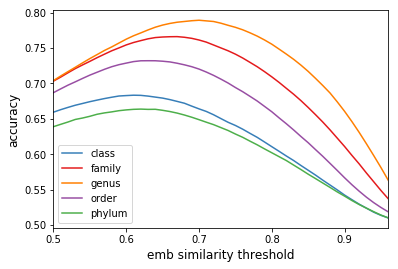

In [125]:
fig, ax = plt.subplots()
colors = sns.color_palette('Set1',5)
color_dict = {}
for ix,tax in enumerate(list(set(metrics['taxlevel']))):
    color_dict[tax] = colors[ix]

for key, grp in metrics.groupby(['taxlevel']):
    ax = grp.plot(ax=ax, kind='line', x='cutoff', y='accuracy', c=color_dict[key], label=key)

plt.legend(loc='best')
plt.ylabel('accuracy',fontsize=12)
plt.xlabel('emb similarity threshold',fontsize=12)

plt.savefig('figures/accvscutoff_alltaxa.png', dpi=150)

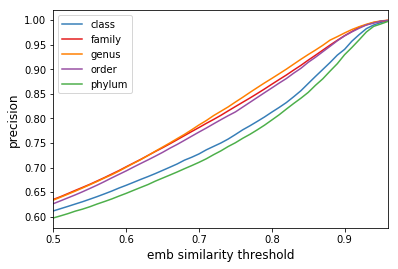

In [126]:
fig, ax = plt.subplots()
colors = sns.color_palette('Set1',5)
color_dict = {}
for ix,tax in enumerate(list(set(metrics['taxlevel']))):
    color_dict[tax] = colors[ix]

for key, grp in metrics.groupby(['taxlevel']):
    ax = grp.plot(ax=ax, kind='line', x='cutoff', y='precision', c=color_dict[key], label=key)

plt.legend(loc='best')
plt.ylabel('precision',fontsize=12)
plt.xlabel('emb similarity threshold',fontsize=12)

plt.savefig('figures/precisionvscutoff_alltaxa.png', dpi=150)

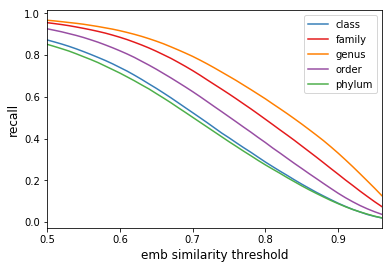

In [127]:
fig, ax = plt.subplots()
colors = sns.color_palette('Set1',5)
color_dict = {}
for ix,tax in enumerate(list(set(metrics['taxlevel']))):
    color_dict[tax] = colors[ix]

for key, grp in metrics.groupby(['taxlevel']):
    ax = grp.plot(ax=ax, kind='line', x='cutoff', y='recall', c=color_dict[key], label=key)

plt.legend(loc='best')
plt.ylabel('recall',fontsize=12)
plt.xlabel('emb similarity threshold',fontsize=12)

plt.savefig('figures/recallvscutoff_alltaxa.png', dpi=150)

In [133]:
for tax in set(metrics['taxlevel']):
    maxx = metrics[metrics['taxlevel']==tax]['accuracy'].max()
    print(tax,':',maxx)
    cutoff = metrics[(metrics['taxlevel']==tax) & (metrics['accuracy']==maxx)]['cutoff']
    print(tax,':',cutoff)
    
metrics[metrics['taxlevel']=='family']

family : 0.7660893398647073
family : 0    0.67
Name: cutoff, dtype: float64
class : 0.6833229840133446
class : 0    0.61
Name: cutoff, dtype: float64
phylum : 0.663704774977939
phylum : 0    0.62
Name: cutoff, dtype: float64
order : 0.7320526790631188
order : 0    0.63
Name: cutoff, dtype: float64
genus : 0.7892419055769505
genus : 0    0.7
Name: cutoff, dtype: float64


,cutoff,accuracy,precision,recall,f1,taxlevel
0,0.50,0.703237,0.635122,0.955283,0.762977,family
0,0.51,0.708957,0.640829,0.950840,0.765644,family
0,0.52,0.715034,0.647065,0.946116,0.768524,family
0,0.53,0.720918,0.653426,0.940868,0.771235,family
0,0.54,0.726125,0.659580,0.934628,0.773377,family
0,0.55,0.731158,0.665833,0.928120,0.775396,family
0,0.56,0.736377,0.672603,0.921122,0.777486,family
0,0.57,0.741253,0.679442,0.913483,0.779269,family
0,0.58,0.746064,0.686646,0.905237,0.780933,family
0,0.59,0.750152,0.693773,0.895626,0.781882,family
